In [ ]:
import os
import os
import re
import cv2
import json
import time
import shutil
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.ensemble import VotingClassifier


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim import Adam
from torchvision import models
from torch.autograd import Variable
from google.colab import drive

%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device set done")

device set done


In [ ]:
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
version = "v1"
for col_name in ['CT_A', 'EC_A', 'EC_P', 'Elv_A', 'Elv_P', 'Sag_A', 'Sag_P']:
    #to hold experiment data
    os.makedirs(f"/content/drive/MyDrive/Colab Notebooks/kera/run_{version}/acc_figure/{col_name}", exist_ok = True)
    os.makedirs(f"/content/drive/MyDrive/Colab Notebooks/kera/run_{version}/loss_figure/{col_name}", exist_ok = True)
    os.makedirs(f"/content/drive/MyDrive/Colab Notebooks/kera/run_{version}/saved_model/{col_name}", exist_ok = True)

for type_ in ["kcn", "nor", "susp"]:
    os.makedirs(f"/content/drive/MyDrive/Colab Notebooks/kera/hist_{type_}", exist_ok = True)
print("done")

done


In [ ]:
def set_seed(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed()

Random seed set as 42


In [ ]:
cls_dict = {
    "Keratoconus": 0,
    "Normal":1,
    "Suspect":2
}
class_list = list(cls_dict.keys())

In [ ]:
def metadata(parnt_dir):
    data_dict = {
        "CT_A" : [],
        "EC_A" : [],
        "EC_P" : [],
        "Elv_A" : [],
        "Elv_P" : [],
        "Sag_A" : [],
        "Sag_P" : [],
        "label": []
    }

    columns = list(data_dict.keys())
    for cls_ in class_list:
        cases_in_pth = os.listdir(os.path.join(parnt_dir, cls_))

        for case in cases_in_pth:
            case_list = os.listdir(os.path.join(parnt_dir, cls_, case))
            for col in columns[:-1]:
                r = re.compile(f".*{col}")
                filename = list(filter(r.match, case_list))[0]
                data_dict[col].append(os.path.join(parnt_dir, cls_, case, filename))
            data_dict["label"].append(cls_dict[cls_])

    df = pd.DataFrame.from_dict(data_dict)
    return df

In [ ]:
df_train = metadata("/content/drive/MyDrive/Colab Notebooks/kera/Train_Validation sets")
df_test = metadata("/content/drive/MyDrive/Colab Notebooks/kera/Independent Test Set")

In [ ]:
df_train.shape[0]

423

In [ ]:
df_test.shape[0]

150

In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)
print(df_train.shape[0])
print(df_test.shape[0])
print(df.shape[0])
df.head()

In [ ]:
def load_and_preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:
X = np.array([np.array([load_and_preprocess_img(img_path) for img_path in row]) for row in df_train[['CT_A', 'EC_A', 'EC_P', 'Elv_A', 'Elv_P', 'Sag_A', 'Sag_P']].values])
X_flat = X.reshape((X.shape[0] * X.shape[1],) + X.shape[2:])


In [ ]:
print(len(X_flat))

2961


In [ ]:
print(X_flat)

In [ ]:
ny = df_train['label'].values
y = [xv for xv in ny for _ in range(7)]
print(len(y))

2961


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)


In [ ]:
print(y_train)

[0, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 1, 2, 0, 2, 0, 2, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 0, 0, 2, 2, 2, 2, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 2, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 2, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 0, 1, 0, 1, 0, 2, 1, 1, 1, 0, 2, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 1, 0, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 0, 1, 2, 1, 0, 0, 1, 2, 1, 1, 0, 0, 

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [ ]:
X_train_features = resnet_model.predict(X_train)

74/74 [==============================] - 470s 6s/step


In [ ]:
X_train_features_flatten = X_train_features.reshape(X_train_features.shape[0], -1)


In [ ]:
svm_model = SVC(kernel='linear')


In [ ]:
svm_model.fit(X_train_features_flatten, y_train)


SVC(kernel='linear')

In [ ]:
X_test_features = resnet_model.predict(X_test)

19/19 [==============================] - 115s 6s/step


In [ ]:
X_test_features_flatten = X_test_features.reshape(X_test_features.shape[0], -1)

In [ ]:
svm_predictions = svm_model.predict(X_test_features_flatten)

In [ ]:
voting_clf = VotingClassifier(estimators=[('svm', svm_model)], voting='hard')

In [ ]:
voting_clf.fit(X_test_features_flatten, y_test)

VotingClassifier(estimators=[('svm', SVC(kernel='linear'))])

In [ ]:
majority_voting_predictions = voting_clf.predict(X_test_features_flatten)

In [ ]:
svm_accuracy = accuracy_score(y_test, svm_predictions)

In [ ]:
majority_voting_accuracy = accuracy_score(y_test, majority_voting_predictions)

In [ ]:
print("SVM Accuracy:", svm_accuracy)
print("Majority Voting Accuracy:", majority_voting_accuracy)

SVM Accuracy: 0.7942664418212478
Majority Voting Accuracy: 1.0


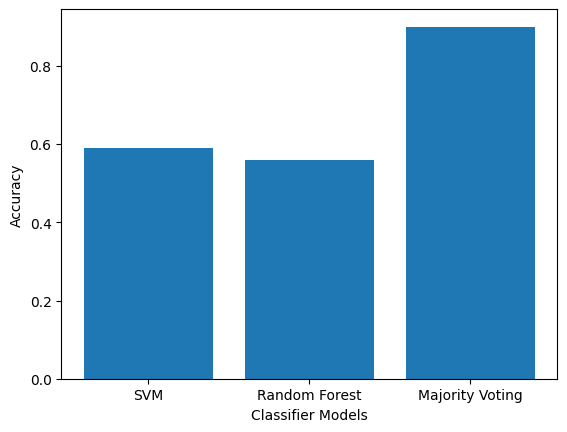

In [2]:
import matplotlib.pyplot as plt

# Sample data
categories = ['SVM', 'Random Forest', 'Majority Voting']
values = [0.59, 0.56, .9]

# Plotting the bar graph
plt.bar(categories, values)

# Adding labels and title
plt.xlabel('Classifier Models')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

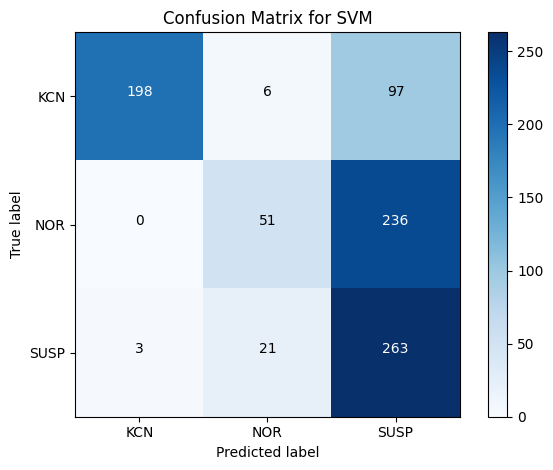

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Example confusion matrix (replace this with your 3x3 array)
conf_matrix = np.array([[198, 6, 97],
                        [0, 51, 236],
                        [3, 21, 263]])

# Plotting confusion matrix as heatmap
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.colorbar()

# Adding axis labels
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['KCN', 'NOR', 'SUSP'])
plt.yticks(tick_marks, ['KCN', 'NOR', 'SUSP'])

# Adding text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()